In [10]:
import time

import torch
import torch.nn as nn
import torch.nn.functional as F

# Check if GPU is available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [11]:
device

device(type='cuda')

In [12]:
import src.CayleyNet as CayleyNet
import src.CORA as CORA
import src.utils as utils

In [13]:
# Reload when files are changed
import importlib
importlib.reload(CayleyNet)
importlib.reload(CORA)
importlib.reload(utils)

<module 'src.utils' from '/home/infres/jalvarez-22/GDA/CayleyNets/src/utils.py'>

In [14]:
# Import dataset
cora = CORA.CORA()

Parsing files...
Done.


In [15]:
# Print properties of the dataset
dataset = cora
print(dataset.description)
print(f'Number of nodes: {dataset.n}')
print(f'Number of edges: {dataset.n_edges}')
print(f'Number of features per node: {dataset.n_features}')

CORA dataset
Number of nodes: 2708
Number of edges: 10556
Number of features per node: 1433


In [7]:
# Extended split of the CORA dataset
train_mask, test_mask, val_mask = utils.split_train_test_val(dataset.n, 500, 500) 

In [8]:
# Features and labels as tensors
features = torch.Tensor(1.0*dataset.features).to(device)
labels = torch.Tensor(dataset.labels).long().to(device)
edge_index = dataset.get_edge_index().to(device)

# Masks as tensors
train_mask = torch.Tensor(train_mask).bool().to(device)
test_mask = torch.Tensor(test_mask).bool().to(device)
val_mask = torch.Tensor(val_mask).bool().to(device)

In [9]:
# Hyperparameters (Section 4.5)
in_feats = dataset.n_features
n_classes = dataset.n_classes
n_hidden = 16
n_hidden_layers = 1 # number of hidden layers
r = 5 # Cayley polynomial order 
# obs: we weren't able to identify the value of this last parameter in the paper

In [10]:
p_dropout=0.5
normalization = 'sym'
model = CayleyNet.CayleyNet(in_feats, n_classes, n_hidden, n_hidden_layers, r=r, p_dropout=p_dropout, normalization=normalization, sparse=False, seed=0)

/home/infres/jalvarez-22/miniconda3/lib/python3.10/site-packages/torch/nn/modules/module.py:1133: UserWarning: Complex modules are a new feature under active development whose design may change, and some modules might not work as expected when using complex tensors as parameters or buffers. Please file an issue at https://github.com/pytorch/pytorch/issues/new?template=bug-report.yml if a complex module does not work as expected.
  warnings.warn(


In [11]:
print(model)
print(f'Number of parameters: {sum(p.numel() for p in model.parameters())}')
print(f'Number of parameters: {sum(p.numel() for p in model.layers[0].parameters())}')
print(f'Number of parameters: {sum(p.numel() for p in model.layers[1].parameters())}')           

CayleyNet(
  (layers): ModuleList(
    (0): CayleyConv(1433, 16, r=5, normalization=sym)
    (1): CayleyConv(16, 7, r=5, normalization=sym)
  )
)
Number of parameters: 23042
Number of parameters: 22929
Number of parameters: 113


In [12]:
# Optimizer
lr = 5e-3
weight_decay = 5e-4
optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)

In [13]:
# Train the model
batch_size = 32
epochs = 200

# save loss values for plotting
loss_values = []
val_score = []
train_score = []

verbose = True
for e in range(epochs):
    start = time.time()

    # Compute output
    logp = model(features, edge_index)

    # Compute loss
    loss = F.nll_loss(logp[train_mask], labels[train_mask])
    loss_values.append(loss.item())

    # Perform backward pass
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    # Evaluation
    score = utils.eval_pytorch_geometric_model(model, edge_index, features, labels, train_mask)
    train_score.append(score)

    score = utils.eval_pytorch_geometric_model(model, edge_index, features, labels, val_mask)
    val_score.append(score)

    # Print loss
    end = time.time()
    if verbose:
        print("Epoch {:02d} | Loss {:.3f} | Accuracy (validation) {:.3f} | Elapsed time: {:.2f}s".format(e, loss.item(), score, end - start))

Epoch 00 | Loss 2.127 | Accuracy (validation) 0.158 | Elapsed time: 2.10s
Epoch 01 | Loss 1.958 | Accuracy (validation) 0.200 | Elapsed time: 1.53s
Epoch 02 | Loss 1.872 | Accuracy (validation) 0.250 | Elapsed time: 1.54s
Epoch 03 | Loss 1.799 | Accuracy (validation) 0.274 | Elapsed time: 1.54s
Epoch 04 | Loss 1.731 | Accuracy (validation) 0.294 | Elapsed time: 1.54s
Epoch 05 | Loss 1.665 | Accuracy (validation) 0.308 | Elapsed time: 1.54s


KeyboardInterrupt: 

In [14]:
test_score = utils.eval_pytorch_geometric_model(model, edge_index, features, labels, test_mask)
print("Test accuracy {:.3f}".format(test_score))

Test accuracy 0.340


In [15]:
results = {'model': 'CayleyNet',
           'dataset': dataset.name,
           'training size': len(train_mask),
           'validation size': len(val_mask),
           'test size': len(test_mask),
           'n hidden nodes': n_hidden,
           'n hidden layers': n_hidden_layers,
           'polynomial order': r,
           'laplacian normalization': normalization,
           'dropout probability': p_dropout,
           'learning rate': lr,
           'weight decay': weight_decay,
           'batch size': batch_size,
           'n epochs': epochs,
           'loss': loss_values,
           'train accuracy': train_score,
           'validation accuracy': val_score,
           'test accuracy': test_score
           }

In [16]:
import pickle
import datetime
ts = datetime.datetime.now()
ts = '{}-{}-{}-{}-{}-{}'.format(ts.year, ts.month, ts.day, ts.hour, ts.minute, ts.second)
fname = './results/cayley_{}.pkl'.format(ts)
with open(fname, 'wb') as f:
    pickle.dump(results, f)
        
with open(fname, 'rb') as f:
    loaded_results = pickle.load(f)

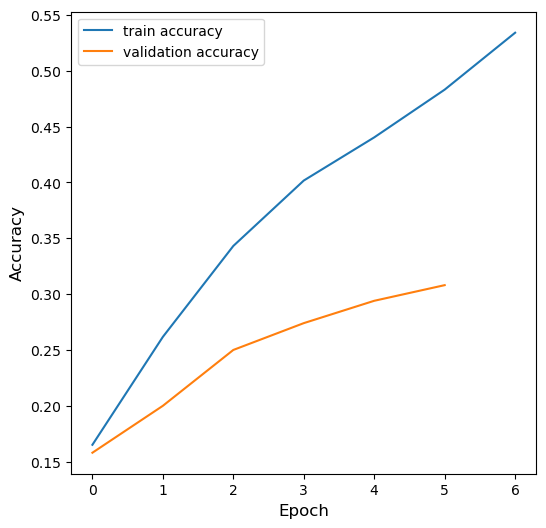

In [17]:
utils.plot_accuracy(loaded_results['train accuracy'], loaded_results['validation accuracy'])

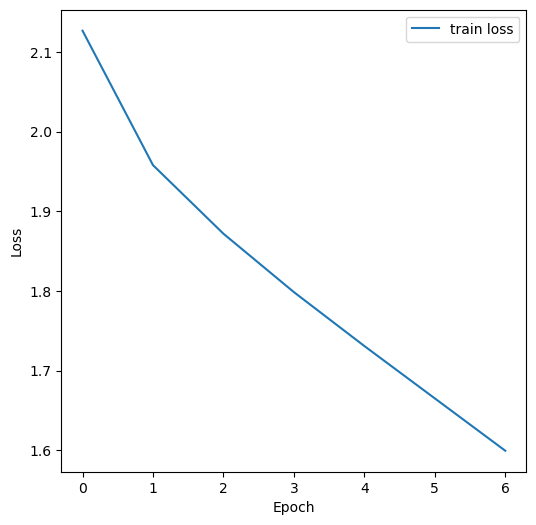

In [18]:
utils.plot_loss(loaded_results['loss'])

In [19]:
print("Test accuracy {:.3f}".format(loaded_results['test accuracy']))

Test accuracy 0.340


# CayLeyNet for community detection

In [16]:
import src.CommunitiesGraph as CG
import numpy as np

In [70]:
n_community=15
p=0.5
q=0.001
n=1000
graph = CG.CommunitiesGraph(n_community, p, q, n)


train_mask, test_mask, val_mask = utils.split_train_test_val(n, 0.2, 0.1)

print(f'Number of nodes: {n}')
print(f'Number of edges: {len(edge_index[0])}')
print(f'Number of features per node: {features.shape[1]}')

print(f'Number of training nodes: {len(labels[train_mask])}')
print(f'Number of validation nodes: {len(labels[val_mask])}')
print(f'Number of test nodes: {len(labels[test_mask])}')

Adj = graph.adjacency

edge_index = np.array(Adj.nonzero())

edge_index_train = edge_index[:, train_mask[edge_index[0]] & train_mask[edge_index[1]]]
edge_index_val = edge_index[:, val_mask[edge_index[0]] & val_mask[edge_index[1]]]
edge_index_test = edge_index[:, test_mask[edge_index[0]] & test_mask[edge_index[1]]]

print(f'Number of training edges: {len(edge_index_train[0])}')
print(f'Number of validation edges: {len(edge_index_val[0])}')
print(f'Number of test edges: {len(edge_index_test[0])}')






Number of nodes: 1000
Number of edges: 33810
Number of features per node: 1
Number of training nodes: 700
Number of validation nodes: 100
Number of test nodes: 200
Number of training edges: 16702
Number of validation edges: 332
Number of test edges: 1346


In [59]:
# Hyperparameters
hidden_channels = 32
feature_channels = 1
r = 10
jacobi_iters = 5
sparse = False
dropout = 0.5
normalization = 'sym'
bias = True

model = CayleyNet.CayleyNet(feature_channels,n_classes=n_community, n_hidden=hidden_channels, n_layers=1, r=r, p_dropout=dropout, normalization=normalization, sparse=sparse, seed=0)

/home/infres/jalvarez-22/miniconda3/lib/python3.10/site-packages/torch/nn/modules/module.py:1133: UserWarning: Complex modules are a new feature under active development whose design may change, and some modules might not work as expected when using complex tensors as parameters or buffers. Please file an issue at https://github.com/pytorch/pytorch/issues/new?template=bug-report.yml if a complex module does not work as expected.
  warnings.warn(


In [60]:
importlib.reload(CayleyNet)
# Optimizer
lr = 5e-3
weight_decay = 5e-4
optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)

In [40]:
model.train()
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
criterion = nn.CrossEntropyLoss()
 

# train the model
for epoch in range(200):
    optimizer.zero_grad()
    out = model(features, edge_index)
    loss = F.nll_loss(out, labels)
    loss.backward()
    optimizer.step()

        
    print('Epoch %d | Loss: %.4f' % (epoch+1, loss.item()))

Epoch 1 | Loss: 4.2526
Epoch 2 | Loss: 4.2173
Epoch 3 | Loss: 4.1013


Epoch 4 | Loss: 3.9817
Epoch 5 | Loss: 4.2454
Epoch 6 | Loss: 4.0936
Epoch 7 | Loss: 4.0260
Epoch 8 | Loss: 4.0063
Epoch 9 | Loss: 4.1360
Epoch 10 | Loss: 4.1563
Epoch 11 | Loss: 3.8719
Epoch 12 | Loss: 4.0954
Epoch 13 | Loss: 4.0167
Epoch 14 | Loss: 4.1370
Epoch 15 | Loss: 3.9760
Epoch 16 | Loss: 3.9634
Epoch 17 | Loss: 3.7669
Epoch 18 | Loss: 3.6953
Epoch 19 | Loss: 3.9408
Epoch 20 | Loss: 4.1353
Epoch 21 | Loss: 3.9262
Epoch 22 | Loss: 3.9001
Epoch 23 | Loss: 4.0372
Epoch 24 | Loss: 3.9146
Epoch 25 | Loss: 3.9191
Epoch 26 | Loss: 3.8344
Epoch 27 | Loss: 4.1076
Epoch 28 | Loss: 3.7171
Epoch 29 | Loss: 4.0804
Epoch 30 | Loss: 3.9394
Epoch 31 | Loss: 3.7346
Epoch 32 | Loss: 3.9048
Epoch 33 | Loss: 3.8292
Epoch 34 | Loss: 4.0613
Epoch 35 | Loss: 3.9995
Epoch 36 | Loss: 3.8263
Epoch 37 | Loss: 3.8009
Epoch 38 | Loss: 3.7705
Epoch 39 | Loss: 3.7397
Epoch 40 | Loss: 3.8682
Epoch 41 | Loss: 3.7209
Epoch 42 | Loss: 3.8102
Epoch 43 | Loss: 3.9039
Epoch 44 | Loss: 3.8587
Epoch 45 | Loss: 3.828